# **Imports & Functions**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import random
from glob import glob
from pathlib import Path
import os
import tensorflow.keras as keras
from sklearn.metrics import recall_score
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import shutil

In [ ]:
def plotter(history_dict):
  """
  Plots loss, val_loss of multiple models on the same graph.

  Input:
   - history_dict: dictionary of model names (keys) and history objects (values)
  """
  plt.figure(figsize=(8, 6))
  plt.xscale('log')
  #plt.xlim([5, max(plt.xlim())])
  plt.ylim([0.1, 1])
  plt.grid(True)
  
  for model_name in history_dict.keys(): # loop over the passed model names
    history = history_dict[model_name] # get history variable from the dictionary
    plt.plot(history.history['loss'],
             linestyle='-', # solid line
             label = model_name + ' Train')
    plt.plot(history.history['val_loss'],
             linestyle='--', # dashed line
             label = model_name + ' Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

  plt.legend(loc='lower left')
  plt.show()

In [ ]:
def find_max(arr):
    #find maximum value
    max_value = np.array([])
    for i, j in zip(arr,range(len(arr))):
        max_val = np.where(i==max(i))
        max_value = np.append(max_value,  max_val)
    return max_value

# **Downloading & Exploring Dataset**

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1f0wcVsmm6TjyxY-mllo-uPu3zLta7dkh'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [ ]:
!mkdir /content/data
!unzip -q /content/archive.zip -d /content/data

In [ ]:
rootdir = '/content/data'
TRAIN_DIR = '/content/data/train'
TEST_DIR = '/content/data/test'
VAL_DIR = '/content/data/validation'

In [ ]:
all_data= [y for x in os.walk(rootdir) for y in glob(os.path.join(x[0], '*png'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]

In [ ]:
classes = ['Normal', 'Seizure']

# split the data to training, testing and validation 

for i in classes:
    os.makedirs(rootdir +'/train/' + i)

    os.makedirs(rootdir +'/test/' + i)

    os.makedirs(rootdir +'/validation/' + i)

    source = rootdir + '/' + i

    allFileNames = os.listdir(source)

    np.random.shuffle(allFileNames)

    ratio1 = 0.4

    ratio2 = 0.5

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - ratio1))])
    
    test_FileNames, val_FileNames = np.split(np.array(test_FileNames),
                                                          [int(len(test_FileNames)* (1 - ratio2))])
    
    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]
    val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]

    for name in train_FileNames:
      shutil.copy(name, rootdir +'/train/' + i)

    for name in test_FileNames:
      shutil.copy(name, rootdir +'/test/' + i)

    for name in val_FileNames:
      shutil.copy(name, rootdir +'/validation/' + i)

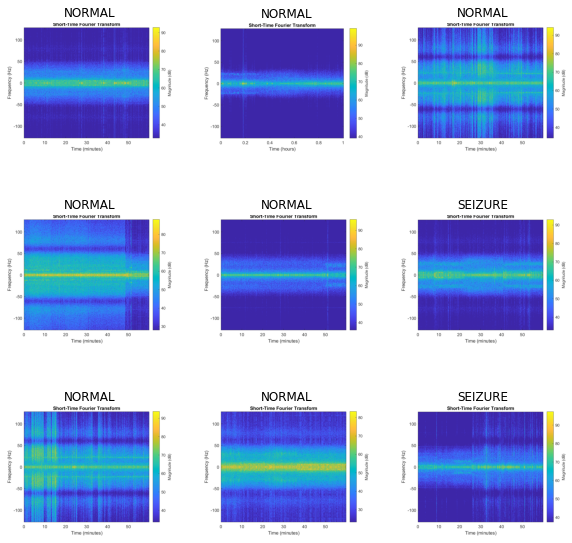

In [ ]:
# Sample 9 images from Seizure and Normal
indices = np.random.randint(0, len(all_data), size=9)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 9 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(3, 3, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i].upper())
    plt.axis('off')
    
plt.show()

# **Training & Testing Models**

## **Hyperparameters**

In [ ]:
#Training Parameters
EPOCHS = 25
base_learning_rate = 0.001
Optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate)
EarlyStopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

In [ ]:
#Classification Head Creation
def MakeModel(Transfer_Model):
  for layer in Transfer_Model.layers:
    layer.trainable = False

  x = Flatten()(Transfer_Model.layers[-1].output)
  x = Dense(758, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  output = Dense(2, activation='softmax')(x)

# return new model
  return Model(inputs = Transfer_Model.inputs, outputs = output)


In [ ]:
#Dict to save losses for comparison
histories = {} 

## **ResNet50 Model**

>> ### **Defining Generators**

In [ ]:
BATCH_SIZE = 20
HEIGHT = 512
WIDTH = 512

train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=40,
      horizontal_flip=True,
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 327 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical')

Found 109 images belonging to 2 classes.


In [ ]:
test_generator =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    )

test_generator = test_generator.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle = False,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 109 images belonging to 2 classes.


>> ### **Train and Test Model**

In [ ]:
# ResNet50 Model
model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "ResNet50_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['ResNet50']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 52.3394 - accuracy: 0.5291
Epoch 1: val_loss improved from inf to 40.54994, saving model to ResNet50_checkpoint.h5
17/17 [==============================] - 56s 3s/step - loss: 52.3394 - accuracy: 0.5291 - val_loss: 40.5499 - val_accuracy: 0.5229
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 33.7165 - accuracy: 0.5780
Epoch 2: val_loss improved from 40.54994 to 14.67689, saving model to ResNet50_checkpoint.h5
17/17 [==============================] - 40s 2s/step - loss: 33.7165 - accuracy: 0.5780 - val_loss: 14.6769 - val_accuracy: 0.5138
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 24.6872 - accuracy: 0.4862
Epoch 3: val_loss improved from 14.67689 to 5.14174, saving model to ResNet50_checkpoint.h5
17/17 [==============================] - 40s 2s/step - loss: 24.6872 - accuracy: 0.4862 - val_loss: 5.1417 - val_accuracy: 0.6147
Epoch 4/25
17/17 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, test_generator.n // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("ResNet50 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

<ipython-input-21-99e8f8017145>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, test_generator.n // BATCH_SIZE+1)


6/6 [==============================] - 3s 385ms/step - loss: 0.5336 - accuracy: 0.6881
ResNet50 Model's Test Accuracy Is 68.80733966827393%
Recall =  0.7543859649122807


## **VGG16 Model**

>> ### **Defining Generators**

In [ ]:
BATCH_SIZE = 20
HEIGHT = 512
WIDTH = 512

train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=40,
      horizontal_flip=True,
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 327 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical')

Found 109 images belonging to 2 classes.


In [ ]:
test_generator =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    )

test_generator = test_generator.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle = False,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 109 images belonging to 2 classes.


>> ### **Train and Test Model**

In [ ]:
# VGG16 Model
model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "VGG16_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['VGG16']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 76.7881 - accuracy: 0.5046
Epoch 1: val_loss improved from inf to 68.76973, saving model to VGG16_checkpoint.h5
17/17 [==============================] - 53s 3s/step - loss: 76.7881 - accuracy: 0.5046 - val_loss: 68.7697 - val_accuracy: 0.5229
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 29.7638 - accuracy: 0.5352
Epoch 2: val_loss improved from 68.76973 to 7.66001, saving model to VGG16_checkpoint.h5
17/17 [==============================] - 36s 2s/step - loss: 29.7638 - accuracy: 0.5352 - val_loss: 7.6600 - val_accuracy: 0.6239
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 11.7647 - accuracy: 0.5474
Epoch 3: val_loss improved from 7.66001 to 2.77295, saving model to VGG16_checkpoint.h5
17/17 [==============================] - 36s 2s/step - loss: 11.7647 - accuracy: 0.5474 - val_loss: 2.7730 - val_accuracy: 0.5780
Epoch 4/25
17/17 [==============================] - ETA: 0s - 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, test_generator.n // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("VGG16 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

<ipython-input-32-ff4bb6824455>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)


6/6 [==============================] - 4s 520ms/step - loss: 0.6834 - accuracy: 0.5596
VGG16 Model's Test Accuracy Is 55.96330165863037%
Recall =  1.0


## **VGG19 Model**

>> ### **Defining Generators**

In [ ]:
BATCH_SIZE = 20
HEIGHT = 512
WIDTH = 512

train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=40,
      horizontal_flip=True,
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 327 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical')

Found 109 images belonging to 2 classes.


In [ ]:
test_generator =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input
    )

test_generator = test_generator.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle = False,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 109 images belonging to 2 classes.


>> ### **Train and Test Model**

In [ ]:
# VGG19 Model
model = VGG19(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "VGG19_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['VGG19']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 117.5822 - accuracy: 0.5566
Epoch 1: val_loss improved from inf to 28.72756, saving model to VGG19_checkpoint.h5
17/17 [==============================] - 41s 2s/step - loss: 117.5822 - accuracy: 0.5566 - val_loss: 28.7276 - val_accuracy: 0.5688
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 31.9969 - accuracy: 0.5749
Epoch 2: val_loss improved from 28.72756 to 5.42110, saving model to VGG19_checkpoint.h5
17/17 [==============================] - 38s 2s/step - loss: 31.9969 - accuracy: 0.5749 - val_loss: 5.4211 - val_accuracy: 0.6789
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 12.3218 - accuracy: 0.5780
Epoch 3: val_loss improved from 5.42110 to 2.62973, saving model to VGG19_checkpoint.h5
17/17 [==============================] - 39s 2s/step - loss: 12.3218 - accuracy: 0.5780 - val_loss: 2.6297 - val_accuracy: 0.6239
Epoch 4/25
17/17 [==============================] - ETA: 0s 

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, test_generator.n // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("VGG19 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

<ipython-input-41-9365f4cd7f73>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)


6/6 [==============================] - 4s 624ms/step - loss: 0.6529 - accuracy: 0.7890
VGG19 Model's Test Accuracy Is 78.899085521698%
Recall =  0.9649122807017544


# **Compare Different Models**

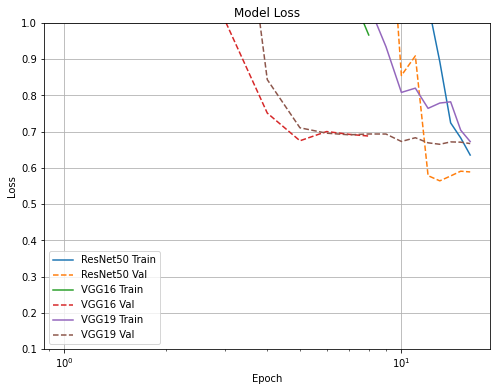

In [ ]:
plotter(histories)